In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.ticker as ticker
from livelossplot import PlotLosses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    print(torch.cuda.get_device_name())
    device = 'cuda'
else:
    print("No GPU available! Running on CPU")

No GPU available! Running on CPU


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
price = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/002230.csv')['end']

# scale price # need to done

x = []
y = []

for w in price.rolling(window=30):
  if len(w) != 30:
    continue
  w = w.values.tolist()
  target = w.pop() # the 31th item
  x.append(w)
  y.append(target)

# transform to tensor
x = torch.tensor(x)
y= torch.tensor(y)

# seperate train test # need to done
# x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.3)

# the real test data
x_test = price[-30:].values
print(x_test)

print(len(x),len(y))
print(len(price))
print(len(price)-30+1)
(x[-1],y[-1])
price

[33.43 33.43 33.9  33.72 34.   34.4  33.16 33.83 34.04 33.9  33.28 32.13
 31.88 32.96 33.36 32.8  33.13 32.63 33.1  32.83 34.37 34.15 34.42 33.94
 34.04 34.12 33.2  33.31 33.26 35.18]
3456 3456
3485
3456


0        1.40
1        1.63
2        1.68
3        1.68
4        1.60
        ...  
3480    34.12
3481    33.20
3482    33.31
3483    33.26
3484    35.18
Name: end, Length: 3485, dtype: float64

In [23]:
class StockDataset(TensorDataset):
  def __init__(self,data,seq_len,target_len=1):
    '''csv: csv file name
    seq_len: length of the sequence input
    target_len: length of the output'''
    self.data = pd.Series([data.iloc[0] for i in range(seq_len)]+list(data.values)) # make it as pd series, because want to use builtin rolling window
    windows = self.data.rolling(window=(seq_len+1)) # rolling window
    self.x, self.y = torch.zeros((len(data),1,seq_len)), torch.zeros((len(data),1,target_len)) # create the x, y as input and target respectively
    # x.shape --> (total,1,30); y.shape --> (total,1,1)
    count = 0
    for w in windows:
      w = w.values
      if len(w) != seq_len+1:
        continue
      else: # only record window that is exact length with seq_len + target_len --> can be seperate as x, y
        target = w[-int(target_len):]
        self.x[count,0] = torch.tensor(w[:seq_len], dtype=torch.float32)
        self.y[count,0] = torch.tensor(target, dtype=torch.float32)
        count += 1

    self.seq_len = seq_len
    self.target_len = target_len
  
  def norm_base(self):
    return self.data.max()

  def norm(self,input):
    return input/self.data.max()

  def __getitem__(self,idx):
    return self.norm(self.x[idx]),self.norm(self.y[idx])

  def __len__(self):
    return len(self.x)


In [13]:
s = StockDataset(price,30)
# print(s[len(s)-2])
# print(s[len(s)-1])#
print(len(s))
next(iter(s))


3485


(tensor([[0.0207, 0.0207, 0.0207, 0.0207, 0.0207, 0.0207, 0.0207, 0.0207, 0.0207,
          0.0207, 0.0207, 0.0207, 0.0207, 0.0207, 0.0207, 0.0207, 0.0207, 0.0207,
          0.0207, 0.0207, 0.0207, 0.0207, 0.0207, 0.0207, 0.0207, 0.0207, 0.0207,
          0.0207, 0.0207, 0.0207]]), tensor([[0.0207]]))

In [ ]:
# s_dataset = StockDataset(price,30)

# s_dataloader = DataLoader(s_dataset, batch_size=5, shuffle=False)
# s =[]
# for i, j in iter(s_dataloader):
#   print(i)

In [14]:
class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # we will streamline the implementation of the LSTM by combining the
        # weights for all 4 operations (input gate, forget gate, output gate, candidate update)
        self.i2h = nn.Linear(input_size, hidden_size * 4, bias=bias)       # create a linear layer to map from input to hidden space
        self.h2h = nn.Linear(hidden_size, hidden_size * 4, bias=bias)      # create a linear layer to map from previous to current hidden space

        self.reset_parameters()                                            # initialise the parameters

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)

        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, h, c):
        gates = self.i2h(input) + self.h2h(h)                              # apply the weights to both input and previous state
        input_gate, forget_gate, candidate_update, output_gate = gates.chunk(4, 1)  # separate the output into each of the LSTM operations

        # apply the corresponding activations
        i_t = torch.sigmoid(input_gate)                                    
        f_t = torch.sigmoid(forget_gate)
        c_t = torch.tanh(candidate_update)
        o_t = torch.sigmoid(output_gate)

        c = f_t * c + i_t * c_t                                             # calculate the next cell state

        h = o_t * torch.tanh(c)                                             # calculate the next hidden state

        return h, c


In [15]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, bias=False):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.rnn_cell_list = nn.ModuleList()                         # create a list of modules

        # create each layer in the network
        # take care when defining the input size of the first vs later layers
        for l in range(self.num_layers):
            self.rnn_cell_list.append(LSTMCell(self.input_size if l == 0 else self.hidden_size,
                                               self.hidden_size,
                                               self.bias))

        self.h2o = nn.Linear(self.hidden_size, self.output_size)     # create a final linear layer from hidden state to network output

    def init_hidden(self,  batch_size=1):
        # initialise the hidden state and cell state
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(device))

    def forward(self, input, h0, c0):
        # Input of shape (batch_size, seqence length , input_size)
        # Output of shape (batch_size, output_size)

        outs = []

        hidden = []
        cell = []
        for layer in range(self.num_layers):
            hidden.append(h0[layer, :, :])
            cell.append(c0[layer, :, :])

        # iterate over all elements in the sequence
        for t in range(input.size(1)):
            # iterate over each layer
            for layer in range(self.num_layers):
                # apply each layer
                # take care to apply the layer to the input or the
                # previous hidden state depending on the layer number
                if layer == 0:
                    hidden_l, cell_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer], cell[layer])
                else:
                    hidden_l, cell_l = self.rnn_cell_list[layer](hidden[layer-1], hidden[layer], cell[layer])

                # store the hidden and cell state of each layer
                hidden[layer] = hidden_l
                cell[layer] = cell_l

            # the hidden state of the last layer needs to be recorded
            # to be used in the output
            outs.append(hidden_l)

        # calculate output for each element in the sequence
        out = torch.stack([self.h2o(out) for out in outs], dim=1)

        return out

In [16]:
class LSTM_GEN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(LSTM_GEN, self).__init__()
        # define your layers and activations
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = LSTM(self.input_size, self.hidden_size, self.num_layers, self.output_size) # add out LSTM

    def forward(self, x):
        batch_size = x.size(0)
        state_h, state_c = self.lstm.init_hidden(batch_size)    # initialise hidden state
        output = self.lstm(x, state_h, state_c)          # apply the LSTM
        return output


def count_trainable_parameters(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

In [17]:
def train_lstm_gen(model, optimizer, criterion, dataloader):
    model.train()                       # set model to train mode
    train_loss, train_accuracy = 0, 0   # initialise the loss 
    for i, (x, y) in enumerate(dataloader):  # loop over dataset
        x, y = x.to(device), y.to(device)    # send data to device
        optimizer.zero_grad()                # reset the gradients
        y_pred = model(x)                    # get output and hidden state
        loss = criterion(y_pred.permute(0,2,1), y)  # compute the loss (change shape as crossentropy takes input as batch_size, number of classes, d1, d2, ...)
        train_loss += loss
        loss.backward()                      # backpropagate
        optimizer.step()                     # update weights 
    return train_loss/len(dataloader)

def valid_lstm_gen(model, criterion, dataloader):
    model.eval()
    valid_loss = 0 
    for i, (x, y) in enumerate(dataloader):
      x, y = x.to(device), y.to(device)
      y_pred = model(x)
      loss = criterion(y_pred.permute(0,2,1), y)
      valid_loss += loss
    return valid_loss/len(dataloader)


def predict_lstm_gen(data, model, output_size=1):
    model.eval()  # set model to evaluation mode
    for i in range(output_size):  # based on the new generated new data
        x = torch.tensor([[[value for value in data[i:]]]], dtype=torch.float32).to(device)  # take from dataset and send to device
        y_pred = model(x)                                                                 # compute output and hidden state
        last_predict = y_pred[0][-1]                                                 # take last output
        data.append(last_predict.detach().to(device))                                       # get word corresponding to dataset
    return data

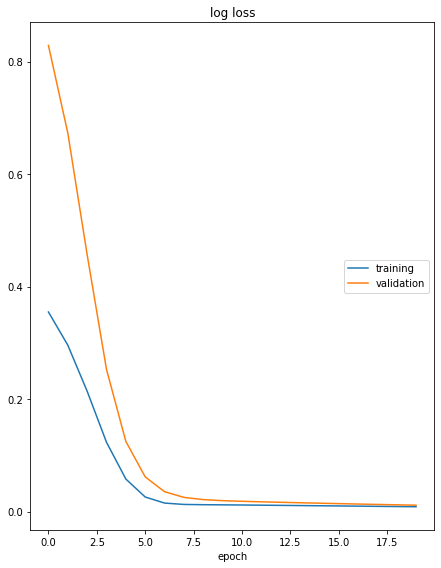

log loss
	training         	 (min:    0.009, max:    0.355, cur:    0.009)
	validation       	 (min:    0.012, max:    0.829, cur:    0.012)
{'log loss': 0.008820885792374611, 'val_log loss': 0.011552714742720127}


In [54]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

input_size = 100
n_hidden = 15                         
n_layers = 2
batch_size = 50
target_len = 10

lr = 2e-4
momentum = 0.5
n_epochs = 20

lstm_gen = LSTM_GEN(input_size,n_hidden,n_layers).to(device)
print(f'The model has {count_trainable_parameters(lstm_gen):,} trainable parameters')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_gen.parameters(), lr=lr)

train_dataset = StockDataset(price[:3000],input_size,target_len)
valid_dataset = StockDataset(price[3001:3300],input_size,target_len)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)  

# Keep track of losses for plotting
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss = train_lstm_gen(lstm_gen, optimizer, criterion, train_dataloader)
    valid_loss = valid_lstm_gen(lstm_gen, criterion, valid_dataloader)
    # print(epoch,train_loss)

    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = valid_loss.item()    
    liveloss.update(logs)
    liveloss.draw()
print(logs)

--------------------------------------------------------------------------

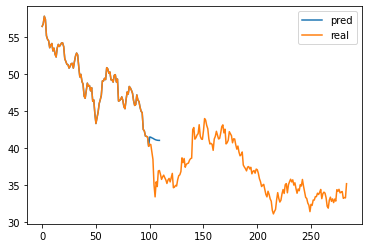

In [57]:
test_set = list(price.iloc[3201:3201+input_size].values)
pred = predict_lstm_gen(list(test_set/max(test_set)), lstm_gen, output_size=target_len)
pred = torch.tensor(pred)*max(test_set)
real = price.iloc[3201:].values
plt.plot(np.arange(0,len(pred)),pred,label='pred')
plt.plot(np.arange(0,len(real)),real,label='real')
plt.legend()

In [ ]:
price.iloc[3201:3201+30]

3201    56.41
3202    56.77
3203    57.78
3204    57.36
3205    55.13
3206    54.67
3207    54.47
3208    53.53
3209    53.90
3210    54.10
3211    53.10
3212    53.47
3213    52.65
3214    52.28
3215    53.50
3216    53.98
3217    53.70
3218    53.91
3219    54.17
3220    54.19
3221    53.69
3222    52.06
3223    51.68
3224    51.29
3225    51.25
3226    50.78
3227    51.01
3228    51.38
3229    51.42
3230    50.78
Name: end, dtype: float64

In [ ]:
price.iloc[3231:]

3231    51.65
3232    52.41
3233    52.81
3234    52.56
3235    50.99
        ...  
3480    34.12
3481    33.20
3482    33.31
3483    33.26
3484    35.18
Name: end, Length: 254, dtype: float64